In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../../../code/statistical_analysis/extinction_analysis/")
from simulator import Simulator, ExtinctionOrder

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=40, use_memory_fs=False)

import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import auc
import seaborn as sns
import scipy.stats as stats

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [15]:
rewiring_prob=0
sim_num=100
sim_types= ["random", "polyploids_first", "diploids_first"]
working_dir = f"../../../data/statistical_analysis/extinction_analysis/rewiring_prob_{rewiring_prob}/"
extinction_simluations_output_path = {sim_type: f"{working_dir}/rewiring_prob_{rewiring_prob}_united_{sim_type}_order_extinction_simulations.csv" for sim_type in sim_types}
weighted_features_data = "../../../data/features/plant/weighted/features_with_classification.csv"
binary_features_data = "../../../data/features/plant/binary/features_with_classification.csv"
binarized_features_data = "../../../data/features/plant/binarized_weighted/features_with_classification.csv"
networks_metadata_path = "../../../data/networks/networks_metadata.csv"
robustness_data_path = f"{working_dir}robustness_data.csv"
aggregated_robustness_data_path = f"../../../data/statistical_analysis/extinction_analysis/rewiring_prob_{rewiring_prob}_aggregated_robustness_data.csv"

In [16]:
first_poly_extinction_data = pd.read_csv(extinction_simluations_output_path["polyploids_first"])
first_di_extinction_data = pd.read_csv(extinction_simluations_output_path["diploids_first"])
random_extinction_data = pd.read_csv(extinction_simluations_output_path["random"])

In [17]:
def get_robustness_measures(df: pd.DataFrame) -> pd.Series:
    return df.groupby(["network_type", "network", "simulation_index"]).parallel_apply(lambda df: auc(df.prop_primary_extinctions, df.prop_secondary_survival))

In [18]:
first_poly_robustness_values = get_robustness_measures(df=first_poly_extinction_data)
first_di_robustness_values = get_robustness_measures(df=first_di_extinction_data)
random_robustness_values = get_robustness_measures(df=random_extinction_data)

In [19]:
first_poly_robustness_values = first_poly_robustness_values.to_frame().sort_index().rename(columns={0: "first_poly_robustness"})
first_di_robustness_values = first_di_robustness_values.to_frame().sort_index().rename(columns={0: "first_di_robustness"})
random_robustness_values = random_robustness_values.to_frame().sort_index().rename(columns={0: "random_robustness"})

robustness_values = first_poly_robustness_values.join(random_robustness_values)
robustness_values = robustness_values.join(first_di_robustness_values)

robustness_values = robustness_values.reset_index()
robustness_values = robustness_values.rename(columns={"network": "network_index"})

assert(min(robustness_values.first_poly_robustness) >= 0)
assert(min(robustness_values.first_di_robustness) >= 0)
assert(min(robustness_values.random_robustness) >= 0)

assert(max(robustness_values.first_poly_robustness) <= 1)
assert(max(robustness_values.first_di_robustness) <= 1)
assert(max(robustness_values.random_robustness) <= 1)

robustness_values.to_csv(robustness_data_path)
robustness_values.isna().sum() / robustness_values.shape[0]

network_type             0.0
network_index            0.0
simulation_index         0.0
first_poly_robustness    0.0
random_robustness        0.0
first_di_robustness      0.0
dtype: float64

In [21]:
agg_mean_robustness_values = robustness_values.dropna().groupby(["network_type", "network_index"]).mean().drop(["simulation_index"], axis=1)
agg_mean_robustness_values = agg_mean_robustness_values.rename(columns={c: f"{c}_mean" for c in agg_mean_robustness_values.columns}).reset_index()
agg_var_robustness_values = robustness_values.dropna().groupby(["network_type", "network_index"]).var().drop(["simulation_index"], axis=1)
agg_var_robustness_values = agg_var_robustness_values.rename(columns={c: f"{c}_var" for c in agg_var_robustness_values.columns}).reset_index()
agg_med_robustness_values = robustness_values.dropna().groupby(["network_type", "network_index"]).median().drop(["simulation_index"], axis=1)
agg_med_robustness_values = agg_med_robustness_values.rename(columns={c: f"{c}_med" for c in agg_med_robustness_values.columns}).reset_index()

agg_robustness_values = agg_mean_robustness_values.merge(agg_var_robustness_values, on=["network_type", "network_index"]).merge(agg_med_robustness_values, on=["network_type", "network_index"])
networks_metadata = pd.read_csv(networks_metadata_path)[["network_type", "network_index", "num_plants", "num_pollinators",
                                                          "num_polyploids", "num_diploids", "num_classified",
                                                         "is_polyploid_poly_frac", "is_polyploid_missing_frac", "frac_sc"]]
agg_robustness_values = agg_robustness_values.merge(networks_metadata, on=["network_type", "network_index"], how="left") 
agg_robustness_values.to_csv(aggregated_robustness_data_path)

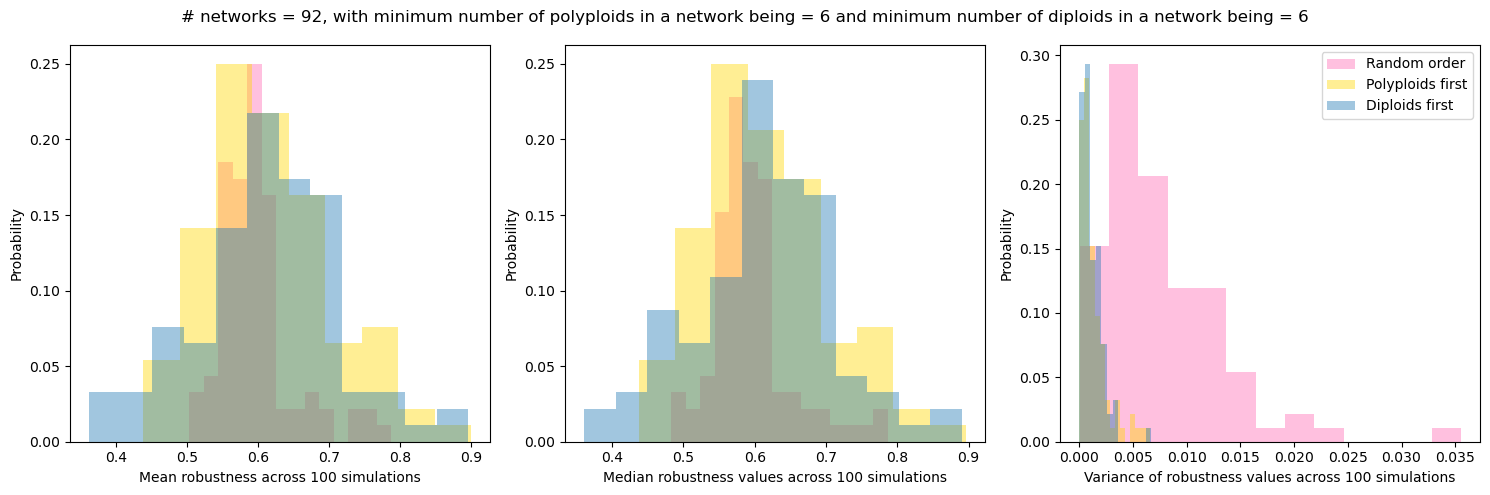

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "gold" #"tab:orange" # yellow, pink, blue
di_color = "tab:blue"
random_color = "hotpink" #"tab:grey"
alpha = 0.42
min_num_class_members = 5 #10

plot_data = agg_robustness_values.loc[(agg_robustness_values.num_polyploids > min_num_class_members)&(agg_robustness_values.num_diploids > min_num_class_members)]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.suptitle(f"# networks = {plot_data.shape[0]}, with minimum number of polyploids in a network being = {int(plot_data.num_polyploids.min())} and minimum number of diploids in a network being = {int(plot_data.num_diploids.min())}")

sns.histplot(plot_data.random_robustness_mean, label="Random order", color=random_color, ax=ax[0], stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_poly_robustness_mean, label="Polyploids first", color=poly_color, ax=ax[0], stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_di_robustness_mean, label="Diploids first", ax=ax[0], color=di_color, stat="probability", alpha=alpha, linewidth=0)
ax[0].set_xlabel("Mean robustness across 100 simulations")

sns.histplot(plot_data.random_robustness_med, label="Random order", color=random_color, ax=ax[1], stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_poly_robustness_med, label="Polyploids first", color=poly_color, ax=ax[1], stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_di_robustness_med, label="Diploids first", ax=ax[1], color=di_color, stat="probability", alpha=alpha, linewidth=0)
ax[1].set_xlabel("Median robustness values across 100 simulations")

sns.histplot(plot_data.random_robustness_var, label="Random order", color=random_color, ax=ax[2], stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_poly_robustness_var, label="Polyploids first", color=poly_color, ax=ax[2], stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_di_robustness_var, label="Diploids first", ax=ax[2], color=di_color, stat="probability", alpha=alpha, linewidth=0)
ax[2].set_xlabel("Variance of robustness values across 100 simulations")
ax[2].legend()

fig.tight_layout()

fig.savefig(f"../../../data/figures/fig5_rewiring_prob_{rewiring_prob}.jpeg")

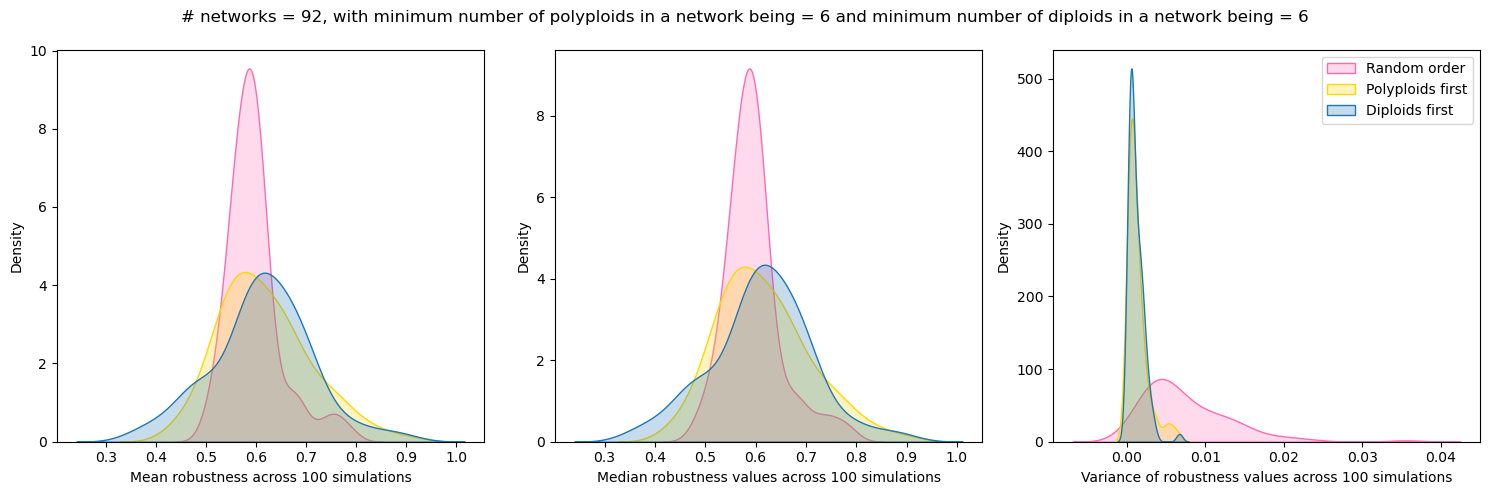

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.suptitle(f"# networks = {plot_data.shape[0]}, with minimum number of polyploids in a network being = {int(plot_data.num_polyploids.min())} and minimum number of diploids in a network being = {int(plot_data.num_diploids.min())}")

sns.kdeplot(plot_data.random_robustness_mean, label="Random order", color=random_color, ax=ax[0], fill=True)
sns.kdeplot(plot_data.first_poly_robustness_mean, label="Polyploids first", color=poly_color, ax=ax[0], fill=True)
sns.kdeplot(plot_data.first_di_robustness_mean, label="Diploids first", ax=ax[0], color=di_color, fill=True)
ax[0].set_xlabel("Mean robustness across 100 simulations")

sns.kdeplot(plot_data.random_robustness_med, label="Random order", color=random_color, ax=ax[1], fill=True)
sns.kdeplot(plot_data.first_poly_robustness_med, label="Polyploids first", color=poly_color, ax=ax[1], fill=True)
sns.kdeplot(plot_data.first_di_robustness_med, label="Diploids first", ax=ax[1], color=di_color, fill=True)
ax[1].set_xlabel("Median robustness values across 100 simulations")

sns.kdeplot(plot_data.random_robustness_var, label="Random order", color=random_color, ax=ax[2], fill=True)
sns.kdeplot(plot_data.first_poly_robustness_var, label="Polyploids first", color=poly_color, ax=ax[2], fill=True)
sns.kdeplot(plot_data.first_di_robustness_var, label="Diploids first", ax=ax[2], color=di_color, fill=True)
ax[2].set_xlabel("Variance of robustness values across 100 simulations")
ax[2].legend()

fig.tight_layout()


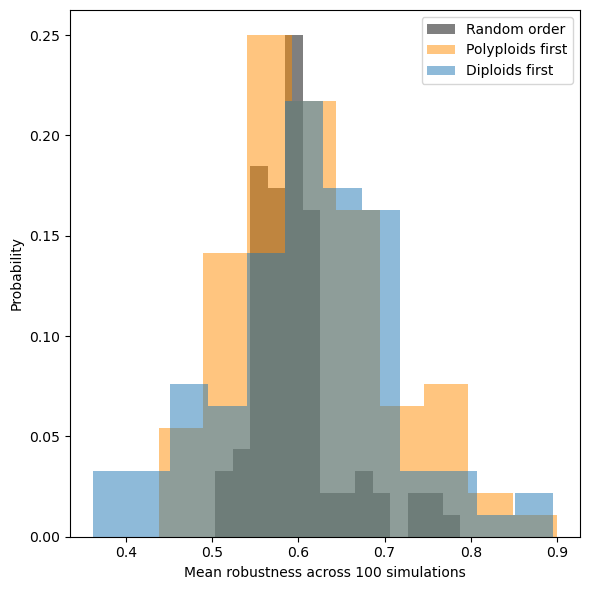

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "darkorange" #"tab:orange" # yellow, pink, blue
di_color = "tab:blue"
random_color = "black" #"tab:grey"
alpha = 0.5
min_num_class_members = 5 #10

plot_data = agg_robustness_values.loc[(agg_robustness_values.num_polyploids > min_num_class_members)&(agg_robustness_values.num_diploids > min_num_class_members)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.histplot(plot_data.random_robustness_mean, label="Random order", color=random_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_poly_robustness_mean, label="Polyploids first", color=poly_color, ax=ax, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(plot_data.first_di_robustness_mean, label="Diploids first", ax=ax, color=di_color, stat="probability", alpha=alpha, linewidth=0)
ax.legend()
ax.set_xlabel("Mean robustness across 100 simulations")
fig.tight_layout()

fig.savefig(f"../../../data/figures/fig5.jpeg")

In [25]:
debug = robustness_values.groupby(["network_type", "network_index"]).agg({'first_poly_robustness': lambda x: len(x.unique()), 
                                                                          'first_di_robustness': lambda x: len(x.unique()),
                                                                          'random_robustness': lambda x: len(x.unique())})
debug = debug.sort_values(["first_poly_robustness", "first_di_robustness", "random_robustness"]).reset_index()
debug = debug.merge(networks_metadata, on=["network_type", "network_index"], how="left") 
plot_debug = debug.loc[(debug.num_polyploids > min_num_class_members) & (debug.num_diploids > min_num_class_members)]
plot_debug.head()

,network_type,network_index,first_poly_robustness,first_di_robustness,random_robustness,num_plants,num_pollinators,num_polyploids,num_diploids,num_classified,is_polyploid_poly_frac,is_polyploid_missing_frac,frac_sc
3,weighted,237,42,46,76,17,16,6,7,13,0.466667,0.210526,0.0
5,weighted,123,46,45,60,12,13,6,6,12,0.500000,0.000000,0.4
13,weighted,99,55,67,89,19,39,6,8,14,0.428571,0.263158,1.0
15,weighted,150,57,68,87,15,34,7,6,13,0.500000,0.125000,0.7
17,weighted,115,58,60,76,15,23,7,8,15,0.466667,0.000000,0.0


In [26]:
from scipy.stats import wilcoxon

wilcoxon(x=plot_data.first_poly_robustness_mean, y=plot_data.first_di_robustness_mean, zero_method='wilcox', correction=False, alternative='two-sided')

WilcoxonResult(statistic=2041.0, pvalue=0.7027567294577559)

In [27]:
# compte random robustness values by viera and almende 2015 to memmot 2004
memmot_data = pd.read_csv("/groups/itay_mayrose/halabikeren/plant_pollinator_networks/data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_weighted_networks_delta_standardized_with_patefield_simulations.csv")
viera_data = plot_data[["network_type", "network_index", "random_robustness_mean", "is_polyploid_poly_frac"]].rename(columns={"random_robustness_mean": "viera_robustness", "is_polyploid_poly_frac": "FracPolyploids"})
memmot_data = memmot_data[["network_type", "network_index", "robustness.LL", "Robustness"]].rename(columns={"robustness.LL": "memmot_robustness",
                                                                                                           "Robustness": "memmot_stand_robustness"})
comp_data = viera_data.merge(memmot_data, on=["network_type", "network_index"])

<AxesSubplot: xlabel='viera_robustness', ylabel='memmot_robustness'>

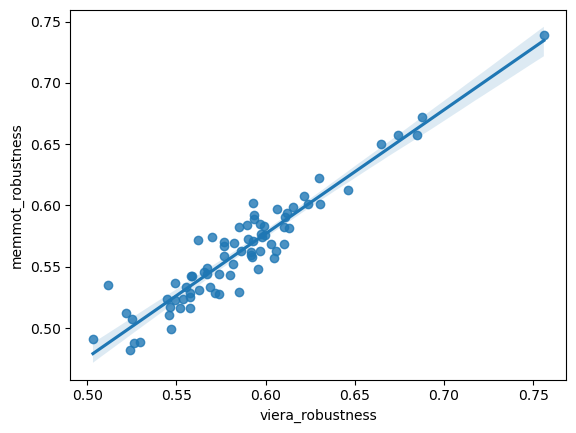

In [28]:
sns.regplot(x=comp_data["viera_robustness"], y=comp_data["memmot_robustness"])

<AxesSubplot: xlabel='memmot_stand_robustness', ylabel='memmot_robustness'>

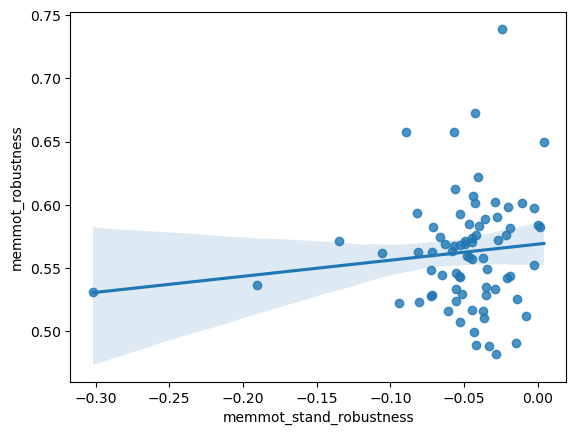

In [29]:
sns.regplot(x=comp_data["memmot_stand_robustness"], y=comp_data["memmot_robustness"])

<AxesSubplot: xlabel='FracPolyploids', ylabel='memmot_stand_robustness'>

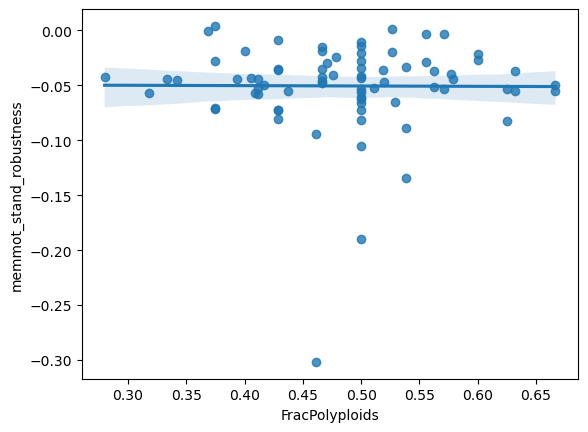

In [30]:
sns.regplot(x=comp_data["FracPolyploids"], y=comp_data["memmot_stand_robustness"])

<AxesSubplot: xlabel='FracPolyploids', ylabel='memmot_robustness'>

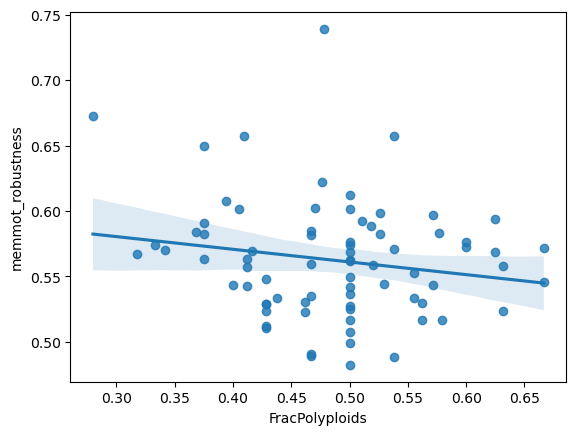

In [31]:
sns.regplot(x=comp_data["FracPolyploids"], y=comp_data["memmot_robustness"])

<AxesSubplot: xlabel='FracPolyploids', ylabel='viera_robustness'>

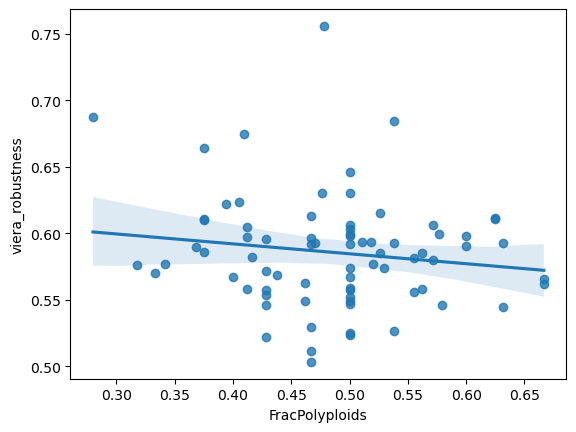

In [32]:
sns.regplot(x=comp_data["FracPolyploids"], y=comp_data["viera_robustness"])